# Exploratory Data Analysis: User Logins Time Series

Steps to be taken:
- Loading and previewing the data
- Data quality checks (sorting, duplicates, missing values, outliers)
- Aggregating logins into 15-minute intervals
- Basic statistics
- Visualizing time series patterns (trends, daily/weekly cycles)
- Advanced analysis (seasonal decomposition, autocorrelation, peak detection)



**Dataset Overview**: ~93,142 login timestamps spanning Jan 1, 1970, to Apr 13, 1970.

**Goals**: Identify patterns like daily cycles, data issues, and demand characteristics.

In [1]:
# Step 1: Import necessary libraries
# - pandas for data manipulation
# - matplotlib and seaborn for visualizations
# - statsmodels for time series decomposition (added for advanced analysis)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# Configure plot style for consistency
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)  # Set default figure size

In [2]:
# Step 2: Load the JSON file into a Pandas DataFrame
# - The data is a list of login timestamps in JSON format
# Preview the first few rows and data info
logins = pd.read_json("logins.json")

print(logins.head())
print(logins.info())

           login_time
0 1970-01-01 20:13:18
1 1970-01-01 20:16:10
2 1970-01-01 20:16:37
3 1970-01-01 20:16:36
4 1970-01-01 20:26:21
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB
None


In [3]:
# Step 3: Convert 'login_time' to datetime and set as index
# - Ensures timestamps are properly parsed as dates
# - Setting as index enables time-based operations like resampling
# Also, sort the index to handle any unsorted data 
logins['login_time'] = pd.to_datetime(logins['login_time'])
logins.set_index('login_time', inplace=True)
logins.sort_index(inplace=True)  # Sort chronologically to fix any out-of-order issues

# Check the time range of the data
print(f"Data from {logins.index.min()} to {logins.index.max()}")

Data from 1970-01-01 20:12:16 to 1970-04-13 18:57:38


## Data Quality Checks

Before analysis, we check for issues like duplicates, missing values, and outliers. This ensures the data is reliable.

- **Duplicates**: Timestamps to the second; multiples possible if simultaneous logins.
- **Missing**: No gaps expected, but verify after resampling.
- **Outliers**: Unusually high/low counts.

In [4]:
# Step 4: Check for duplicates, missing intervals, and basic stats
# - Duplicates: Count how many timestamps are repeated (possible in simulation)
# - We decide to keep duplicates as they may represent multiple logins at the same second
# - Resample temporarily to check for missing intervals
duplicates = logins.index.duplicated().sum()
print(f"Duplicate timestamps: {duplicates}")  # Output: 877 duplicates found

# Resample to 15-min and check for NaNs (missing intervals)
logins_15min = logins.resample('15min').size()
missing = logins_15min.isna().sum()
print(f"Missing intervals after resample: {missing}")  # Output: 0, no gaps

# Basic stats on login counts per 15-min interval
logins_15min.name = 'login_count'
print(logins_15min.describe())

Duplicate timestamps: 877
Missing intervals after resample: 0
count    9788.000000
mean        9.515938
std         8.328818
min         0.000000
25%         3.000000
50%         7.000000
75%        13.000000
max        73.000000
Name: login_count, dtype: float64


## Aggregation and Basic Statistics

Aggregate logins into 15-minute bins to create a time series of counts. This reduces noise and reveals patterns.

In [5]:
# Step 5: Resample into 15-minute intervals and count logins
# - .resample('15min').size() counts occurrences per bin
# - This creates our primary time series for analysis
logins_15min = logins.resample('15min').size()
logins_15min.name = 'login_count'

# Preview the resampled data
print(logins_15min.head())

login_time
1970-01-01 20:00:00    2
1970-01-01 20:15:00    6
1970-01-01 20:30:00    9
1970-01-01 20:45:00    7
1970-01-01 21:00:00    1
Freq: 15min, Name: login_count, dtype: int64


## Visualizations

Visualize to identify trends, cycles, and patterns.

- Time series plot
- Rolling average for trends
- Daily and weekly cycles
- Heatmap for hour-day interactions

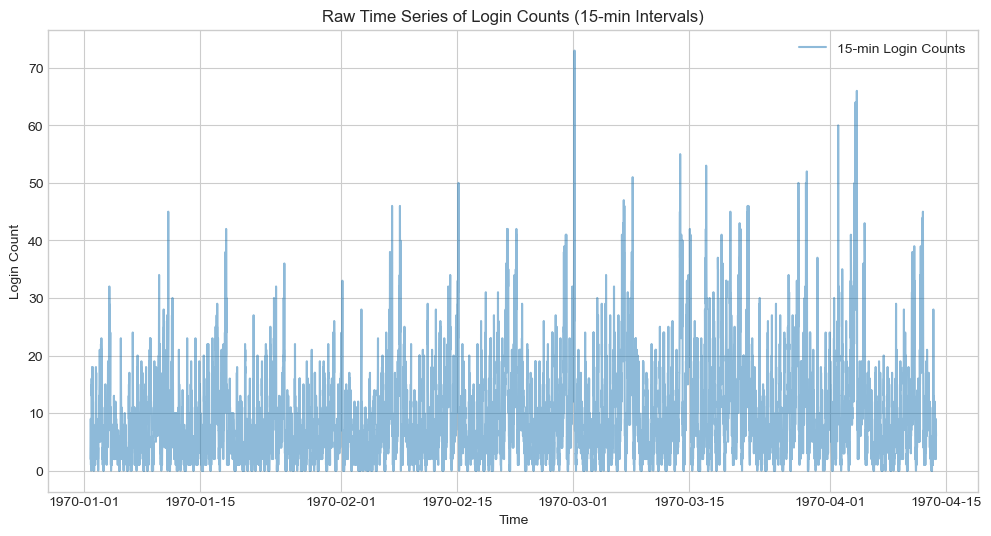

In [6]:
# Step 6: Plot the raw 15-minute login counts
# - Shows volatility and potential spikes
# - Useful for spotting overall patterns before smoothing
plt.plot(logins_15min.index, logins_15min, label='15-min Login Counts', alpha=0.5)
plt.title('Raw Time Series of Login Counts (15-min Intervals)')
plt.xlabel('Time')
plt.ylabel('Login Count')
plt.legend()
plt.show()


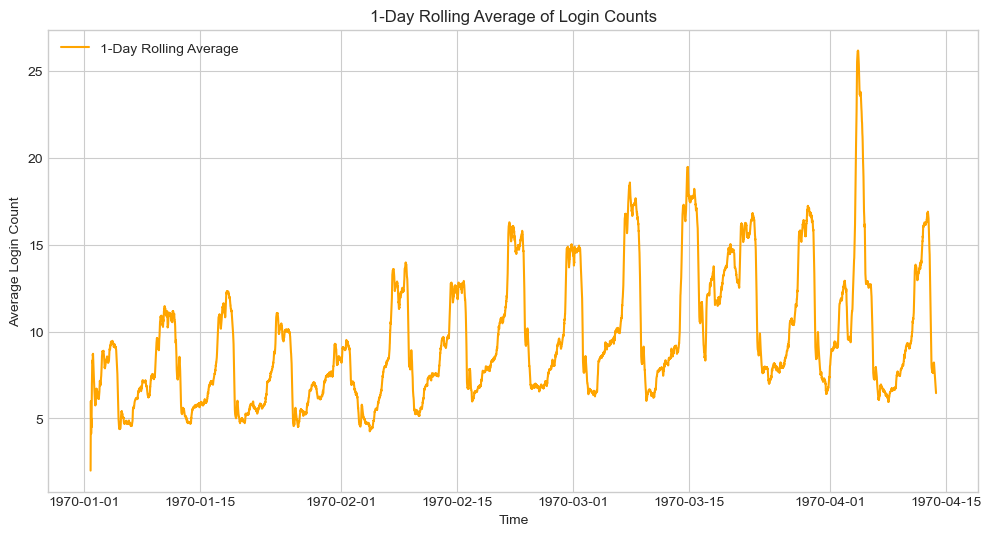

In [7]:
# Step 7: Compute and plot 1-day rolling average
# - Rolling mean smooths short-term fluctuations to reveal trends
# - Window '1D' averages over a day
logins_15min = logins_15min.to_frame()  # Convert to DataFrame for rolling
logins_15min['rolling_1D'] = logins_15min['login_count'].rolling('1D').mean()

plt.plot(logins_15min.index, logins_15min['rolling_1D'], color='orange', label='1-Day Rolling Average')
plt.title('1-Day Rolling Average of Login Counts')
plt.xlabel('Time')
plt.ylabel('Average Login Count')
plt.legend()
plt.show()


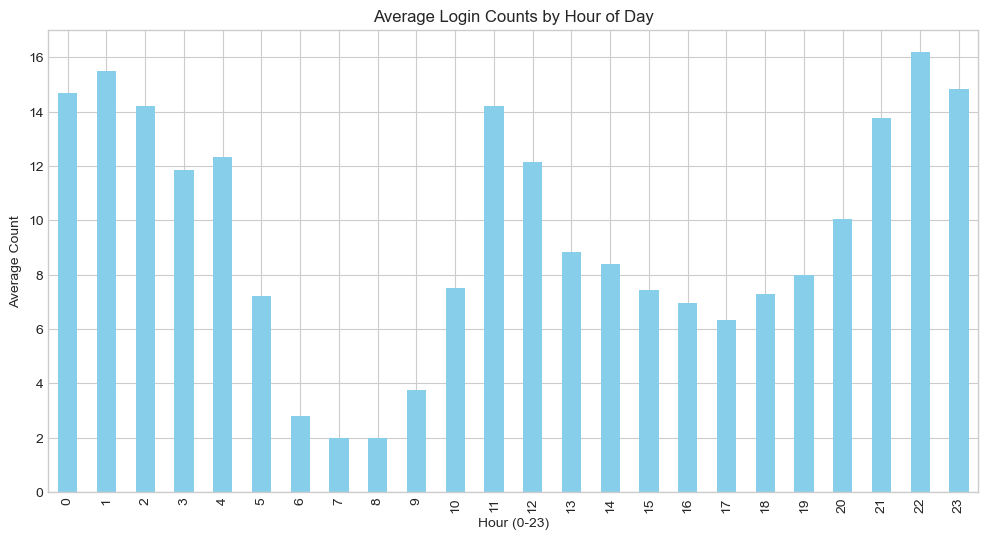

In [8]:
# Step 8: Daily cycle - Average logins by hour of day 
# - Extract hour from index, groupby, mean
# - Reveals intra-day patterns (e.g., nighttime peaks)
logins_15min['hour'] = logins_15min.index.hour
daily_cycle = logins_15min.groupby('hour')['login_count'].mean()

daily_cycle.plot(kind='bar', color='skyblue')
plt.title('Average Login Counts by Hour of Day')
plt.xlabel('Hour (0-23)')
plt.ylabel('Average Count')
plt.show()


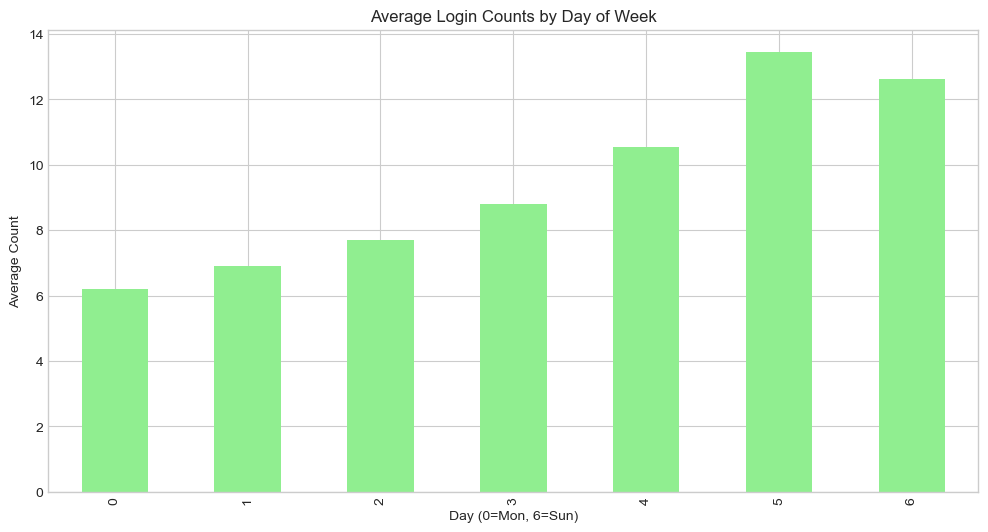

In [9]:
# Step 9: Weekly cycle - Average logins by day of week 
# - Extract dayofweek (0=Mon, 6=Sun), groupby, mean
# - Shows higher demand on weekends
logins_15min['dayofweek'] = logins_15min.index.dayofweek
weekly_cycle = logins_15min.groupby('dayofweek')['login_count'].mean()

weekly_cycle.plot(kind='bar', color='lightgreen')
plt.title('Average Login Counts by Day of Week')
plt.xlabel('Day (0=Mon, 6=Sun)')
plt.ylabel('Average Count')
plt.show()



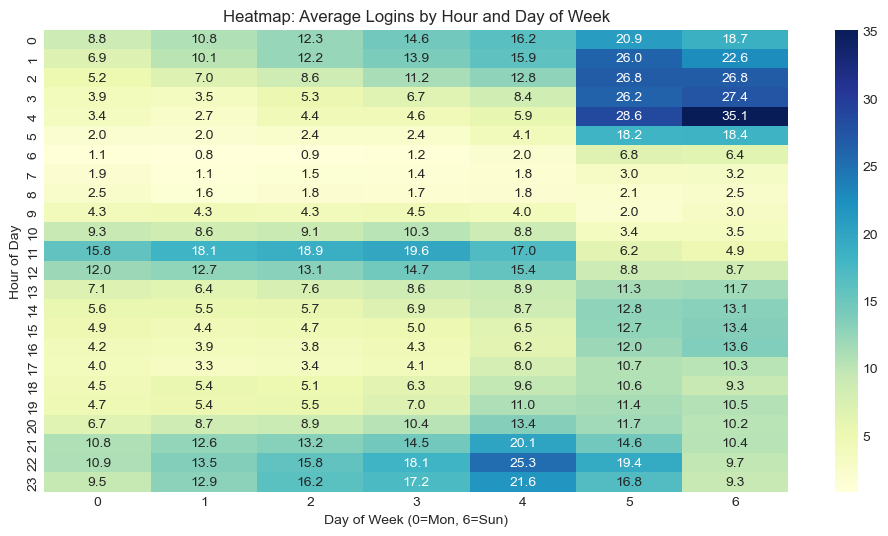

In [10]:
# Step 10: Heatmap of average logins by hour and day of week 
# - Pivot table for 2D view
# - sns.heatmap for visualization
# - Highlights interactions (e.g., weekend nights highest)
heatmap_data = logins_15min.pivot_table(index='hour', columns='dayofweek', values='login_count', aggfunc='mean')

sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt='.1f')
plt.title('Heatmap: Average Logins by Hour and Day of Week')
plt.xlabel('Day of Week (0=Mon, 6=Sun)')
plt.ylabel('Hour of Day')
plt.show()



## Advanced Analysis

Deeper insights: Decompose series into trend/seasonal/residual, check autocorrelation, identify peaks.

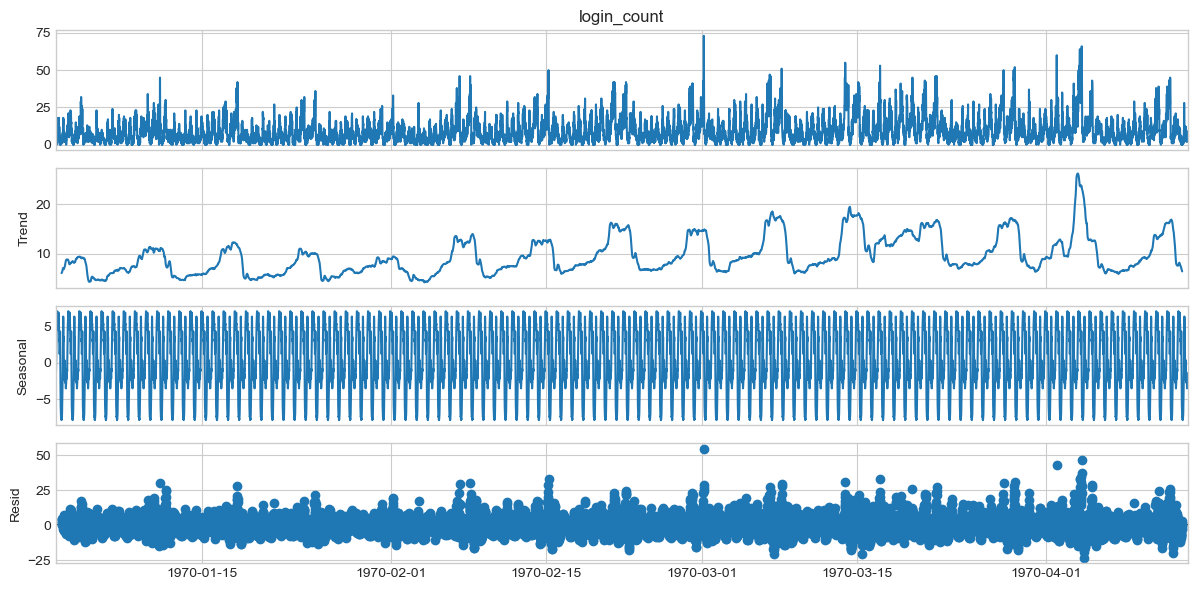

In [11]:
# Step 11: Seasonal decomposition
# - Use statsmodels to decompose into trend, seasonal (daily), residual
# - Period=96 (24 hours * 4 intervals/hour)
# - Helps separate cycles from noise
decomp = seasonal_decompose(logins_15min['login_count'], period=96)  # Daily seasonality
decomp.plot()
#plt.suptitle('Seasonal Decomposition of Login Counts')
plt.show()


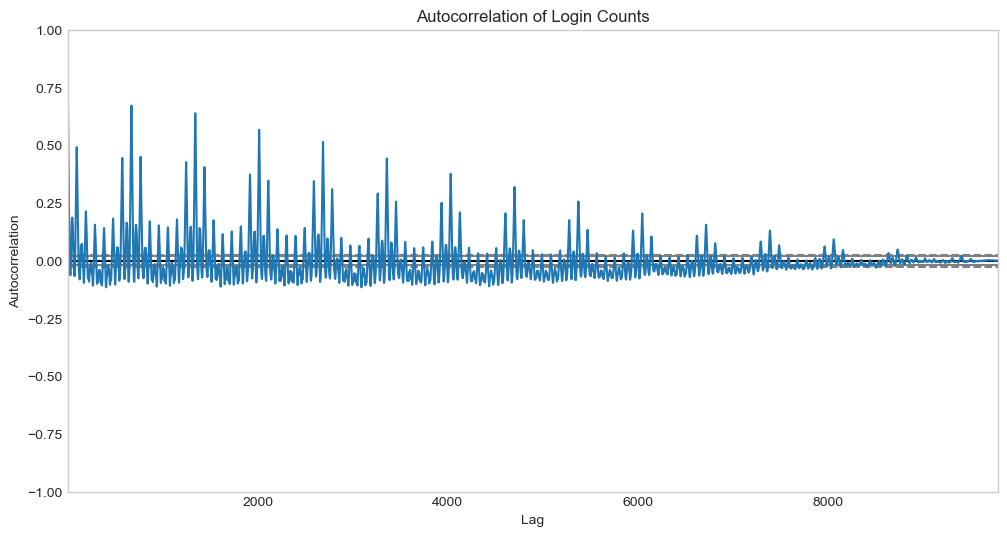

In [12]:
# Step 12: Autocorrelation plot
# - Shows correlation at different lags
# - Peaks at multiples of 96 confirm daily cycles
pd.plotting.autocorrelation_plot(logins_15min['login_count'])
plt.title('Autocorrelation of Login Counts')
plt.show()

# Output: Line plot with spikes at lag 96, 192, etc., indicating strong daily periodicity

In [13]:
# Step 13: Identify top peak intervals
# - Sort descending to find highest demand times
# - Useful for operational insights (e.g., scale resources)
peaks = logins_15min['login_count'].sort_values(ascending=False).head(10)
print("Top 10 Peak Intervals:")
print(peaks)


Top 10 Peak Intervals:
login_time
1970-03-01 04:30:00    73
1970-04-04 05:30:00    66
1970-04-04 01:30:00    64
1970-04-04 01:15:00    63
1970-04-01 23:30:00    60
1970-04-04 05:00:00    60
1970-04-04 04:45:00    59
1970-04-04 05:15:00    59
1970-04-04 01:45:00    56
1970-03-13 22:15:00    55
Name: login_count, dtype: int64


## Conclusions

- **Data Issues**: Minor (duplicates kept as valid); data clean overall.
- **Patterns**: Strong daily (night peaks) and weekly (weekend highs) cycles.
- **Demand**: Bursty, nighttime-focused; average 9.5 logins/15min, max 73.
- **Next Steps**: Forecasting (e.g., ARIMA), anomaly detection.
